# Выбор локации для нефтяной скважины

Нужно решить, где бурить новую скважину добывающей компании «ГлавРосГосНефть». 
Шаги для выбора локации обычно такие:
* В избранном регионе собирают характеристики для скважин: качество нефти и объём её запасов;
* Строят модель для предсказания объёма запасов в новых скважинах;
* Выбирают скважины с самыми высокими оценками значений;
* Определяют регион с максимальной суммарной прибылью отобранных скважин.

Предоставлены пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны. Построим модель для определения региона, где добыча принесёт наибольшую прибыль. Проанализируем возможную прибыль и риски техникой Bootstrap.

## Описание данных

Данные геологоразведки трёх регионов находятся в файлах:
* `geo_data_0.csv`
* `geo_data_1.csv`
* `geo_data_2.csv`

Значения в датасетах:
* `id` — уникальный идентификатор скважины;
* `f0, f1, f2` — три признака точек;
* `product` — объём запасов в скважине (тыс. баррелей).

Условия задачи:
* Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
* При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
* Бюджет на разработку скважин в регионе — 10 млрд рублей.
* При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
* После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

## Иморты и константы

In [1]:
import os
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
sns.set(style="darkgrid")

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings("ignore")

In [14]:
BUILD_BUDGET = 10e9 #бюджет разработки скважины
UNIT_INCOME = 450000 #доход с ед. продукта
WELLS_CNT = 500 #количество скважин для исследования
BEST_WELLS_CNT = 200 #лучшие скважины
RISK_TRESHOLD = 0.025 #максимальный приемлемый риск убытков
CONF_INTERVAL = 0.95
BOOTSTRAP_SAMPLES = 1000
RANDOM_STATE = 12345
PATH_YANDEX = '/datasets/'
PATH_HOME = '/home/aart/datasets/'

## Чтение данных

In [15]:
file_names = ['geo_data_0.csv', 'geo_data_1.csv', 'geo_data_2.csv']
dfs = []

try:
    for file_name in file_names:
        with open(os.path.join(PATH_HOME, file_name)) as f:
            dfs.append(pd.read_csv(f, index_col='id'))
except:
    for file_name in file_names:
        with open(os.path.join(PATH_YANDEX, file_name)) as f:
            dfs.append(pd.read_csv(f, index_col='id'))

<div class="alert alert-success">
<h2> Комментарий ревьюера ✔️ <a class="tocSkip"> </h2>

Здорово, что ты используешь конструкцию `try-except`, это повышает отказоустойчивость кода

</div>


In [4]:
NAs = []
duplicates = []
shapes = []
id_duplicates = []

for df in dfs:
    NAs.append(df.isna().sum().sum())
    duplicates.append(df.duplicated().sum())
    shapes.append(df.shape)
    id_duplicates.append(df.index.duplicated().sum())
    
print('Пропусков в датафреймах:', sum(NAs))
print('Дубликатов в датафреймах:', sum(duplicates))
print('Размеры датафрйемов:', shapes)
print('Дубликатов в индексах:', id_duplicates)

Пропусков в датафреймах: 0
Дубликатов в датафреймах: 0
Размеры датафрйемов: [(100000, 4), (100000, 4), (100000, 4)]
Дубликатов в индексах: [10, 4, 4]


Явных дубликатов нет, но они встречаются в индексах. Впрочем, их отношение к размерам датафреймов настолько мало, что ими можно пренебречь.

В датафреймах нет пропусков, дубликатов, все одинакового размера.

## Работа с моделью

### Features and target, разделение на выборки

In [5]:
def sampling(df, test_size=0.25, random_state=RANDOM_STATE):
    X = df.drop(['product'], axis=1)
    y = df['product']

    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=test_size, random_state=RANDOM_STATE)

    return X_train, X_val, y_train, y_val

In [6]:
def rmse(y_true, y_pred):
    return (mean_squared_error(y_true, y_pred))**(1/2)

results = {'mean': [],
           'RMSE': []}

predictions = {} 
answers = {} #словари предсказаний и целевых значений, помогут при вычислении прибыли
i = 0

for df in dfs: 
    geo_name = file_names[i]
    X_train, X_val, y_train, y_val = sampling(df)
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    answers[geo_name] = np.array(y_val)
    predictions[geo_name] = y_pred
    results['mean'].append(y_pred.mean())
    results['RMSE'].append(rmse(y_val, y_pred)) 
    i+=1

In [7]:
pd.DataFrame(results)

,mean,RMSE
0,92.592568,37.579422
1,68.728547,0.893099
2,94.965046,40.029709


В регионах 0 и 2 средние значение объема в месторождении примерно одинаковые, при этом модели имеют бОльшую погрешность.
В 1 регионе средние запасы нефти в месторождениях ниже, но и погрешность модели значительно ниже.

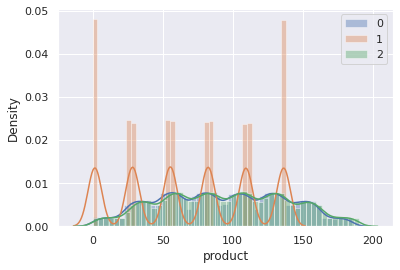

In [8]:
for i, df in enumerate(dfs):
    sns.distplot(df['product'], label=i)
    plt.legend()

Распределнение запасов в месторождении 1 существенно отличается от 0 и 2.

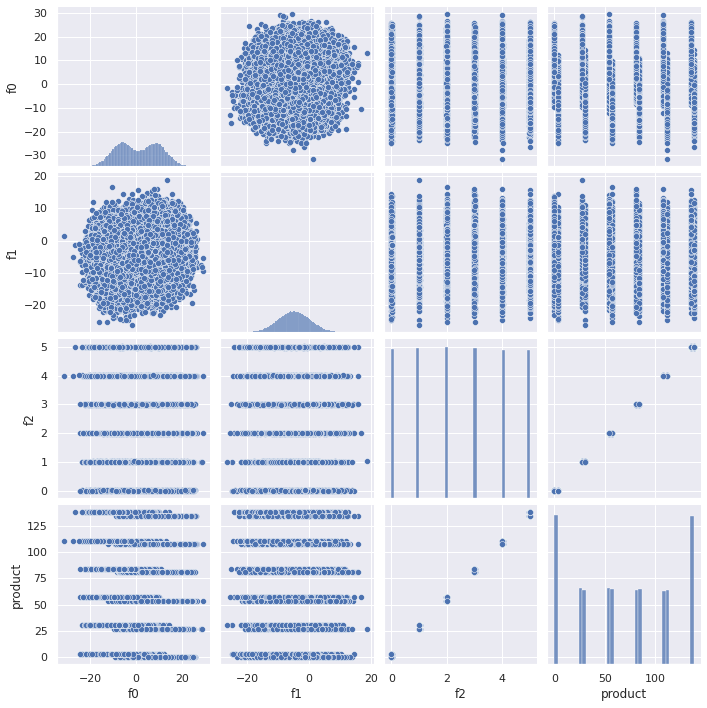

In [9]:
sns.pairplot(dfs[1]);

Показатель `product` линейно коррелирует с признаком `f2`. Это объясняет высокую точность линейной регрессии.

## Расчет прибыли, рисков, вероятности убытков

Прибыль с одной скважины должна быть выше, чем ее бюджет. Вычислим бюджет на одну вышку - разделим весь бюджет `BUILD_BUDGET`, выделяемый на регион, на количество вышек `WELLS_CNT`, которое должны разработать в регионе.
Это значение разделим на прибыль с 1 тысячи баррелей `UNIT_INCOME` - получим оценочное значение объёма сырья, при котором доходы равны расходам

In [10]:
MIN_RAW = (BUILD_BUDGET/BEST_WELLS_CNT)/UNIT_INCOME
MIN_RAW

111.11111111111111

Значение выше, чем средние значения запасов в любом из регионов.
Для минимизации рисков, надо отобрать точки которые потенциально могуть дать больше сырья. Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели

In [11]:
def profit(predicted, target, 
           wells_cnt=BEST_WELLS_CNT, unit_income=UNIT_INCOME, res_budget=BUILD_BUDGET):
    total_product = target[(-predicted).argsort()[:wells_cnt]].sum()
    return total_product * unit_income - res_budget

,geo_data_0.csv,geo_data_1.csv,geo_data_2.csv
"Доверительный интервал, млн. руб.","(-64.27, 776.54)","(108.84, 799.66)","(-61.97, 850.77)"
"Средняя прибыль, млн. руб.",371.89,452.25,395.96
"Вероятность убытков, %",7.4,1.7,7.5


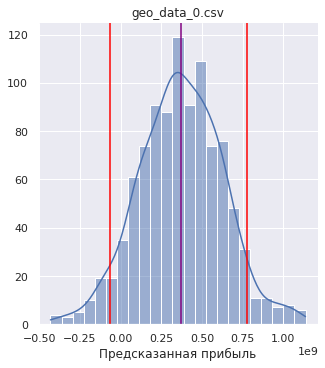

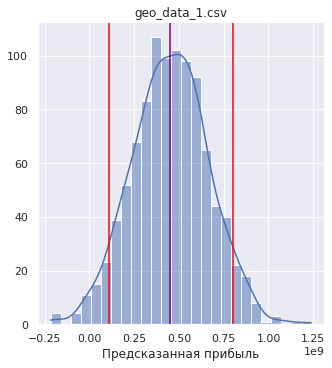

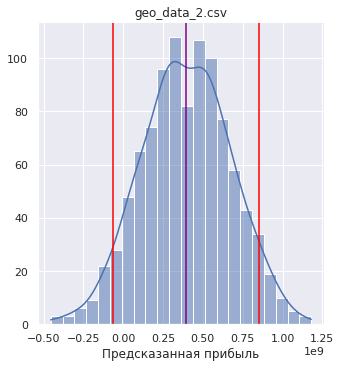

In [13]:
result_table = pd.DataFrame()
for geo in predictions:
    # предсказания и ответы для текущего geo
    product_pred = predictions[geo]
    product_answ = answers[geo]

    # bootstrap
    profits = []
    for i in range(1000):
        id = np.random.randint(0, product_pred.shape[0], WELLS_CNT)
        profits.append(profit(product_pred[id], product_answ[id]))

    # пределы доверительного интервала
    profits = pd.Series(profits)
    lower = profits.quantile(1-CONF_INTERVAL)
    upper = profits.quantile(CONF_INTERVAL)
    sns.displot(data=profits,kde=True,legend=True)
    plt.axvline(x=lower,color='red')
    plt.axvline(x=upper,color='red')
    plt.axvline(x=round(np.mean(profits)),color='purple')
    plt.xlabel('Предсказанная прибыль')
    plt.ylabel('')
    plt.title(geo)

    result_table[geo]= pd.Series({
        'Доверительный интервал, млн. руб.': (round(lower/1e6,2), round(upper/1e6,2)),
        'Средняя прибыль, млн. руб.': round(np.mean(profits)/1e6, 2),
        'Вероятность убытков, %': 100*(profits<0).astype(int).mean()
    })
result_table

Красными линиями на графике обозначен доверительный интервал, фиолетовыми - средняя прибыль для региона.

Регион, описанный в файлу `geo_data_1.csv` неоспоримо является лучшим - он выгодно отличается как и по средней прибыли, так и вероятности убытков.

# Вывод

Было проведено исследование в соответсвии с заданными шагами. С помощью линейной регрессии и bootstrap'a был выделен самый перспективный регион, выгодно отличающийся как по средней предсказанной прибыли, так и по вероятности убытков.
Также в ходе исследования поведения линейной модели было изучено распределения нефти в регионах.

В результате была доказана целесообразность использования моделей машинного обучения для этой задачи, ей можно пользоваться при освоении новых регионов.